In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import cv2

from ssd_model import SSD512
from ssd_utils import PriorUtil

Using TensorFlow backend.


In [2]:
from data_voc import GTUtility
gt_util = GTUtility('data/VOC2007/')
num_classes = gt_util.num_classes

In [3]:
model = SSD512(num_classes=num_classes)
#model.load_weights('ssd512_voc_weights_fixed.hdf5', by_name=True)
model.load_weights('./checkpoints/201709081909_ssd512_voc/weights.020.h5', by_name=True)

priors_util = PriorUtil(model)

8/8 [==============================] - 1s 114ms/step


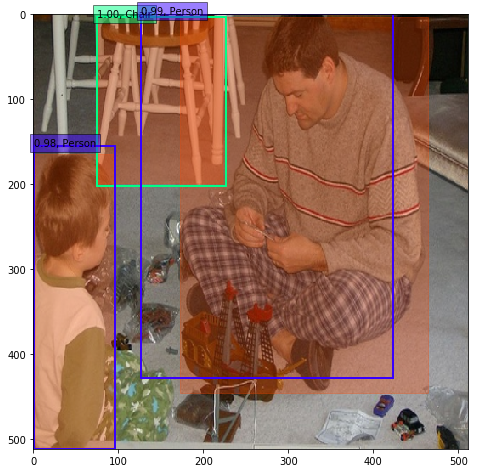

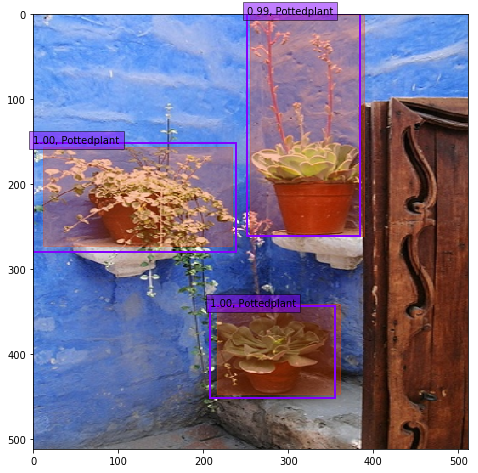

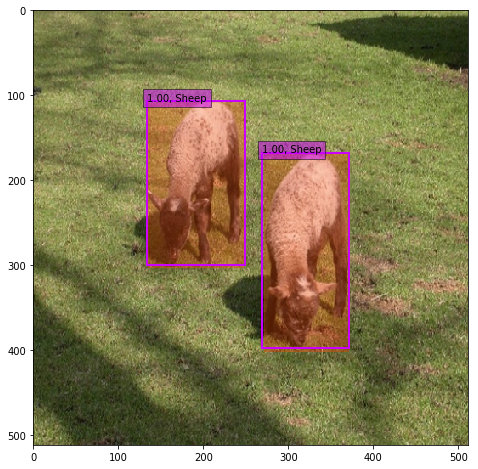

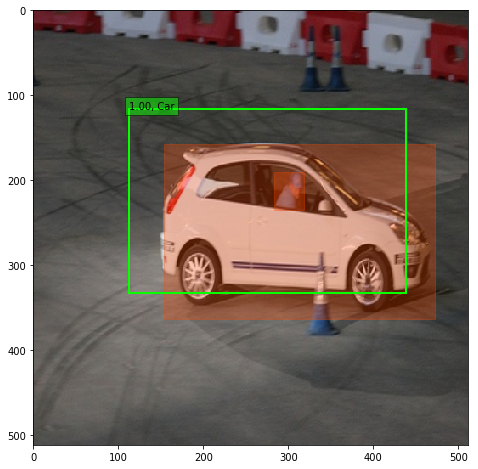

In [4]:
_, inputs, images, data = gt_util.sample_random_batch(batch_size=8, input_size=model.image_size)

preds = model.predict(inputs, batch_size=1, verbose=1)

results = [priors_util.decode(p, confidence_threshold=0.8) for p in preds]

for i in range(4):
    plt.figure(figsize=[8]*2)
    plt.imshow(images[i])
    priors_util.plot_results(results[i], classes=gt_util.classes, 
                             confidence_threshold=0.1, show_labels=True, gt_data=data[i])
    plt.show()

In [5]:
for m in priors_util.prior_maps:
    print('%-28s  locations: %-6i  aspect_ratios: %s' % (m.source_layer_name, m.num_locations, m.aspect_ratios))

conv4_3                       locations: 4096    aspect_ratios: [1, 2]
fc7                           locations: 1024    aspect_ratios: [1, 2, 3]
conv6_2                       locations: 256     aspect_ratios: [1, 2, 3]
conv7_2                       locations: 64      aspect_ratios: [1, 2, 3]
conv8_2                       locations: 16      aspect_ratios: [1, 2, 3]
conv9_2                       locations: 4       aspect_ratios: [1, 2]
conv10_2                      locations: 1       aspect_ratios: [1, 2]


### Multi scale

In [6]:
import tensorflow as tf

from ssd_utils import load_weights

In [7]:
input_shapes = [(512, 512, 3), (1024, 1024, 3)]
input_shapes = [(512, 512, 3), (768, 768, 3), (1024, 1024, 3)]
#input_shapes = [(512, 512, 3), (512, 1024, 3), (1024, 512, 3), (1024, 1024, 3)] # TODO fix this

In [8]:
graphs = []
sessions = []
models = []
prior_utils = []

for i in range(len(input_shapes)):
    graph = tf.Graph()
    graphs.append(graph)
    with graph.as_default():
        session = tf.Session()
        sessions.append(session)
        with session.as_default():
            model = SSD512(input_shape=input_shapes[i], num_classes=gt_util.num_classes)
            models.append(model)
            load_weights(model, './checkpoints/201709081909_ssd512_voc/weights.020.h5')
            prior_util = PriorUtil(model)
            prior_utils.append(prior_util)

layer missing zero_padding2d_1
layer missing conv4_3_norm_mbox_priorbox
layer missing fc7_mbox_priorbox
layer missing conv6_2_mbox_priorbox
layer missing conv7_2_mbox_priorbox
layer missing conv8_2_mbox_priorbox
layer missing conv9_2_mbox_priorbox
layer missing conv10_2_mbox_priorbox
layer missing mbox_priorbox
layer missing zero_padding2d_1
layer missing conv4_3_norm_mbox_priorbox
layer missing fc7_mbox_priorbox
layer missing conv6_2_mbox_priorbox
layer missing conv7_2_mbox_priorbox
layer missing conv8_2_mbox_priorbox
layer missing conv9_2_mbox_priorbox
layer missing conv10_2_mbox_priorbox
layer missing mbox_priorbox
layer missing zero_padding2d_1
layer missing conv4_3_norm_mbox_priorbox
layer missing fc7_mbox_priorbox
layer missing conv6_2_mbox_priorbox
layer missing conv7_2_mbox_priorbox
layer missing conv8_2_mbox_priorbox
layer missing conv9_2_mbox_priorbox
layer missing conv10_2_mbox_priorbox
layer missing mbox_priorbox


In [9]:
from ssd_utils import non_maximum_suppression, non_maximum_suppression_slow

def decode_boxes(self, model_output, confidence_threshold=0.01):
    # calculation is done with normalized sizes

    prior_mask = model_output[:,4:] > confidence_threshold

    # compute boxes only if the confidence is high enough and the class is not background
    mask = np.any(prior_mask[:,1:], axis=1)
    prior_mask = prior_mask[mask]
    mask = np.ix_(mask)[0]
    model_output = model_output[mask]
    priors_xy = self.priors_xy[mask] / self.image_size
    priors_wh = self.priors_wh[mask] / self.image_size
    priors_variances = self.priors[mask,-4:]

    offsets = model_output[:,:4]
    confidence = model_output[:,4:]

    num_priors = offsets.shape[0]
    num_classes = confidence.shape[1]

    # compute bounding boxes from local offsets
    boxes = np.empty((num_priors, 4))
    offsets = offsets * priors_variances
    boxes_xy = priors_xy + offsets[:,0:2] * priors_wh
    boxes_wh = priors_wh * np.exp(offsets[:,2:4])
    boxes[:,0:2] = boxes_xy - boxes_wh / 2. # xmin, ymin
    boxes[:,2:4] = boxes_xy + boxes_wh / 2. # xmax, ymax
    boxes = np.clip(boxes, 0.0, 1.0)

    return boxes, confidence, prior_mask

def decode_nms(boxes, confidence, prior_mask, keep_top_k=200):

    nms_top_k = 400
    nms_thresh = 0.45
    nms_thresh = 0.3

    # do non maximum suppression
    results = []
    for c in range(1, num_classes):
        mask = prior_mask[:,c]
        boxes_to_process = boxes[mask]
        if len(boxes_to_process) > 0:
            confs_to_process = confidence[mask, c]

            idx = non_maximum_suppression_slow(
                    boxes_to_process, confs_to_process, 
                    nms_thresh, nms_top_k)

            good_boxes = boxes_to_process[idx]
            good_confs = confs_to_process[idx][:, None]
            labels = np.ones((len(idx),1)) * c
            c_pred = np.concatenate((good_boxes, good_confs, labels), axis=1)
            results.extend(c_pred)
    if len(results) > 0:
        results = np.array(results)
        order = np.argsort(-results[:, 4])
        results = results[order]
        results = results[:keep_top_k]
    else:
        results = np.empty((0,6))
    return results

In [10]:
inputs = []

for i, s in enumerate(input_shapes):
    _, inpusts_, images, data = gt_util.sample_random_batch(batch_size=8, input_size=s[:2], seed=1337)
    inputs.append(inpusts_)

results_multi = []
for i in range(len(input_shapes)):
    with graphs[i].as_default():
        with sessions[i].as_default():
            model = models[i]
            preds = model.predict(inputs[i], batch_size=1, verbose=1)
            
            #boxes, confidence, prior_mask = 
            results = [ decode_boxes(prior_utils[i], p, confidence_threshold=0.8) for p in preds]
            
            #results = [ prior_utils[i].decode(p, confidence_threshold=0.8) for p in preds]
            results_multi.append(results)

8/8 [==============================] - 1s 161ms/step


In [11]:
results = []
for i in range(len(results_multi[0])):
    boxes = np.vstack([r[i][0] for r in results_multi])
    confidence = np.vstack([r[i][1] for r in results_multi])
    prior_mask = np.vstack([r[i][2] for r in results_multi])
    results.append( decode_nms(boxes, confidence, prior_mask) )

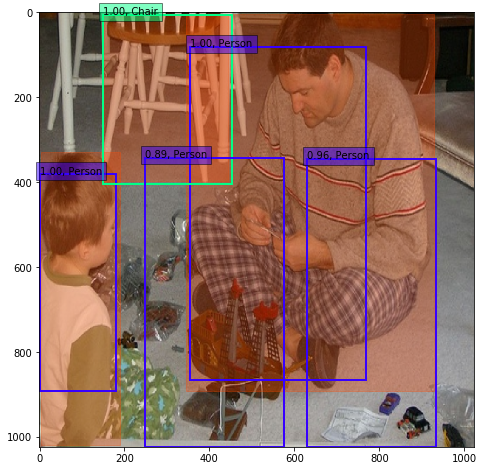

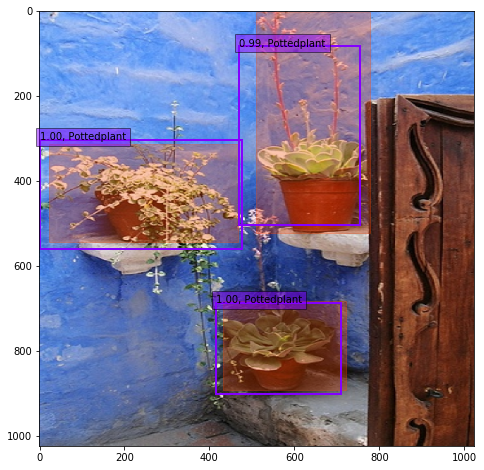

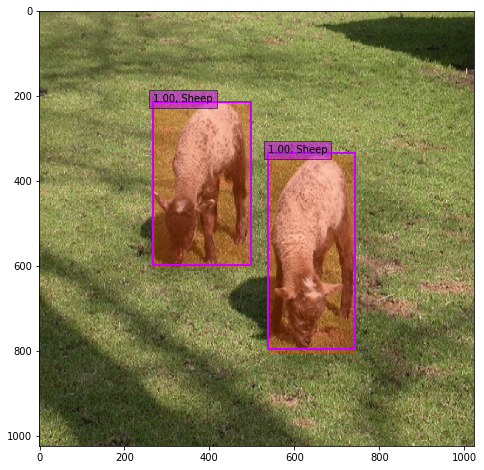

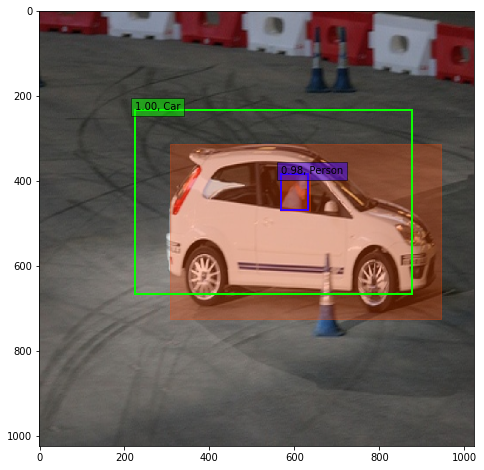

In [12]:
for i in range(4):
    plt.figure(figsize=[8]*2)
    plt.imshow(images[i])
    prior_util.plot_results(results[i], classes=gt_util.classes, show_labels=True, gt_data=data[i])
    plt.show()